# SubX PNA DJF Weather Regimes

This program:
1. Read in the Z500 anomalies from SubX models 
2. Project the Z500 anomalies onto the ERA-Interim EOFs to get the `projected PCs`
3. Identify the Cluster assignment for each day of the SubX hindcast:
   * For each model daily Z500 projected PC, associate that model state with the reanalysis regime centroid to which it is closest (Eulerian distance) in PC-space.

Test plans:
* Model - GMAO
* K=5
* Hindcast Date: All Jans
* Ensemble members: ensemble mean

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import pickle
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker

### Read in the kmeans model for k=5 using `pickle`

In [2]:
kmeans_fname = 'kmeans5_model.sav'
kmeans = pickle.load(open(kmeans_fname, "rb"))

### Set Parameters

In [3]:
# SubX
model='GMAO-GEOS_V2p1'
varname='zg'
varlev='500'
subx_path='/shared/subx/hindcast/'
fcst_init_date='*01*'

# OBS/Rean
rean_path='/project/predictability/kpegion/wxregimes/era-interim/'
rean_eof_file='erai.z500_u250_pna_5dyrm_DJF.1980-2015.eofs.nc'

### Read SubX Data

In [4]:
fname_z500=subx_path+'zg500/daily/anoms/'+model+'/zg_500'+'_'+model+'_'+fcst_init_date+'.anoms.daily.nc'
ds_z500=xr.open_mfdataset(fname_z500,combine='nested',concat_dim='init')
ds_z500

fname_u200=subx_path+'ua200/daily/anoms/'+model+'/ua_200'+'_'+model+'_'+fcst_init_date+'.anoms.daily.nc'
ds_u200=xr.open_mfdataset(fname_u200,combine='nested',concat_dim='init')
ds_u200


ds_z500=ds_z500.where(ds_z500['zg']!=-9.99e-8)
ds_u200=ds_u200.where(ds_u200['ua']!=-9.99e-8)

ds=xr.merge([ds_z500.dropna(dim='init'),ds_u200.dropna(dim='init')])

### Rename variables

In [5]:
#fcst_dates=pd.date_range(start=fcst_init_date,periods=len(ds['time']),freq='D')
#ds['time']=fcst_dates
ds=ds.rename({'zg':'z500','ua':'u200'})
ds

,Array,Chunk
Bytes,7.47 GB,11.73 MB
Shape,"(637, 45, 181, 360)","(1, 45, 181, 360)"
Count,33871 Tasks,637 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,7.47 GB,11.73 MB
Shape,"(637, 45, 181, 360)","(1, 45, 181, 360)"
Count,19567 Tasks,637 Chunks
Type,float32,numpy.ndarray


### Read the ERA-INTERIM EOFs

In [6]:
eofs_ds=xr.open_dataset(rean_path+rean_eof_file)
eofs_ds

<xarray.Dataset>
Dimensions:  (eofnum: 12, lat: 22, lon: 53)
Coordinates:
  * eofnum   (eofnum) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * lat      (lat) float64 79.53 76.74 73.95 71.16 ... 29.3 26.51 23.72 20.93
  * lon      (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
Data variables:
    z500     (eofnum, lat, lon) float64 ...
    u250     (eofnum, lat, lon) float64 ...

### Interpolate SubX Data to Reanalysis Grid

In [7]:
ds_interp=ds.interp_like(eofs_ds)
ds_interp

,Array,Chunk
Bytes,133.69 MB,209.88 kB
Shape,"(637, 45, 22, 53)","(1, 45, 22, 53)"
Count,35145 Tasks,637 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,133.69 MB,209.88 kB
Shape,"(637, 45, 22, 53)","(1, 45, 22, 53)"
Count,20841 Tasks,637 Chunks
Type,float32,numpy.ndarray


### Project Z500 anomalies onto Z500 Reanalysis EOFS to get `projected PCs`

In [8]:
# Get dimensions for numpy operations
nx=len(eofs_ds['lon'])
ny=len(eofs_ds['lat'])
neofs=len(eofs_ds['eofnum'])
nt=len(ds['time'])
nics=len(ds['init'])

In [9]:
# Reshape EOFS to neofs X space
X=eofs_ds['z500'].values.reshape(neofs,nx*ny)
X.shape

(12, 1166)

In [10]:
# Reshape SubX anomalies to time X space
Y=ds_interp['z500'].values.reshape(nics*nt,nx*ny)

# Matrix multiplication of X and Y to get projected PCs
pc_proj=np.matmul(X,Y.T)
pc_proj.shape
    
# Identify the cluster for all inits for a given lead
y_kmeans=kmeans.predict(pc_proj.T)
y_kmeans.shape

(28665,)

In [11]:
ds_cluster=xr.DataArray(y_kmeans.reshape(nics,nt),
                        coords={'init':ds['init'],'time':ds['time']},
                        dims=['init','time'])
ds_cluster=xr.merge([ds_interp,ds_cluster.to_dataset(name='cluster')])
ds_cluster = ds_cluster.set_coords(['cluster'])
ds_cluster

,Array,Chunk
Bytes,133.69 MB,209.88 kB
Shape,"(637, 45, 22, 53)","(1, 45, 22, 53)"
Count,35145 Tasks,637 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,133.69 MB,209.88 kB
Shape,"(637, 45, 22, 53)","(1, 45, 22, 53)"
Count,20841 Tasks,637 Chunks
Type,float32,numpy.ndarray


### Test Cluster Composite

In [12]:
#cluster_comp=ds_cluster.groupby('cluster').mean() 
#cluster_comp

In [14]:
nclusters=5
tmp_z500=np.zeros((nt,nclusters,ny,nx))
tmp_u200=np.zeros((nt,nclusters,ny,nx))
for ilead in range(nt):
    print(ilead)
    tmp_z500[ilead,:,:,:]=ds_cluster['z500'][:,ilead,:,:].groupby('cluster').mean(dim='init')  
    tmp_u200[ilead,:,:,:]=ds_cluster['u200'][:,ilead,:,:].groupby('cluster').mean(dim='init')  

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


In [19]:
cluster_comp_z500=xr.DataArray(tmp_z500,
                        coords={'time':ds_interp['time'],'clusters': np.arange(nclusters),
                                'lat':ds_interp['lat'],'lon':ds_interp['lon']},
                        dims=['time','clusters','lat','lon'])
cluster_comp_u200=xr.DataArray(tmp_u200,
                        coords={'time':ds_interp['time'],'clusters': np.arange(nclusters),
                                'lat':ds_interp['lat'],'lon':ds_interp['lon']},
                        dims=['time','clusters','lat','lon'])
cluster_comp=xr.merge([cluster_comp_z500.to_dataset(name='z500'),
                       cluster_comp_u200.to_dataset(name='u200')])
cluster_comp

<xarray.Dataset>
Dimensions:   (clusters: 5, lat: 22, lon: 53, time: 45)
Coordinates:
  * time      (time) datetime64[ns] 1960-01-01T12:00:00 ... 1960-02-14T12:00:00
  * clusters  (clusters) int64 0 1 2 3 4
  * lat       (lat) float64 79.53 76.74 73.95 71.16 ... 29.3 26.51 23.72 20.93
  * lon       (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
Data variables:
    z500      (time, clusters, lat, lon) float64 73.64 75.06 ... 2.396 3.096
    u200      (time, clusters, lat, lon) float64 4.627 4.886 ... 1.08 0.7756

### Set Map Information

In [25]:
titles=['Arctic High','Arctic Low','Alaskan Ridge','Pacific Wavetrain','Pacific Trough']

lat_labels=np.arange(20,90,20)
lon_labels=np.arange(150,330,30)
extent=[minlon,maxlon,20,90]

cm = 220
minlon = -70 + cm
maxlon = 80 + cm
levs=np.arange(-210,220,30)
clevs=[-12,-10,-9,-6,-3,0,3,6,9,10,12]
data_crs = ccrs.PlateCarree(central_longitude=cm)
proj = ccrs.NorthPolarStereo(central_longitude=cm)

0
10
20
30
40


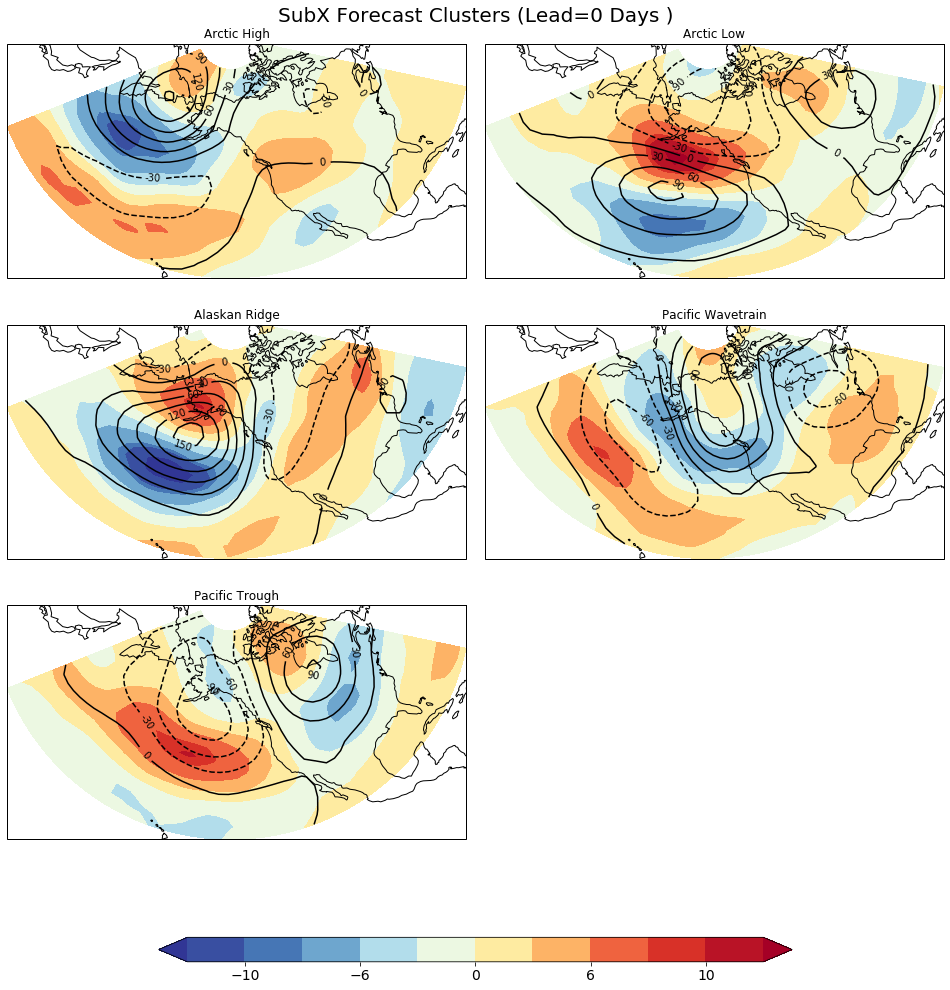

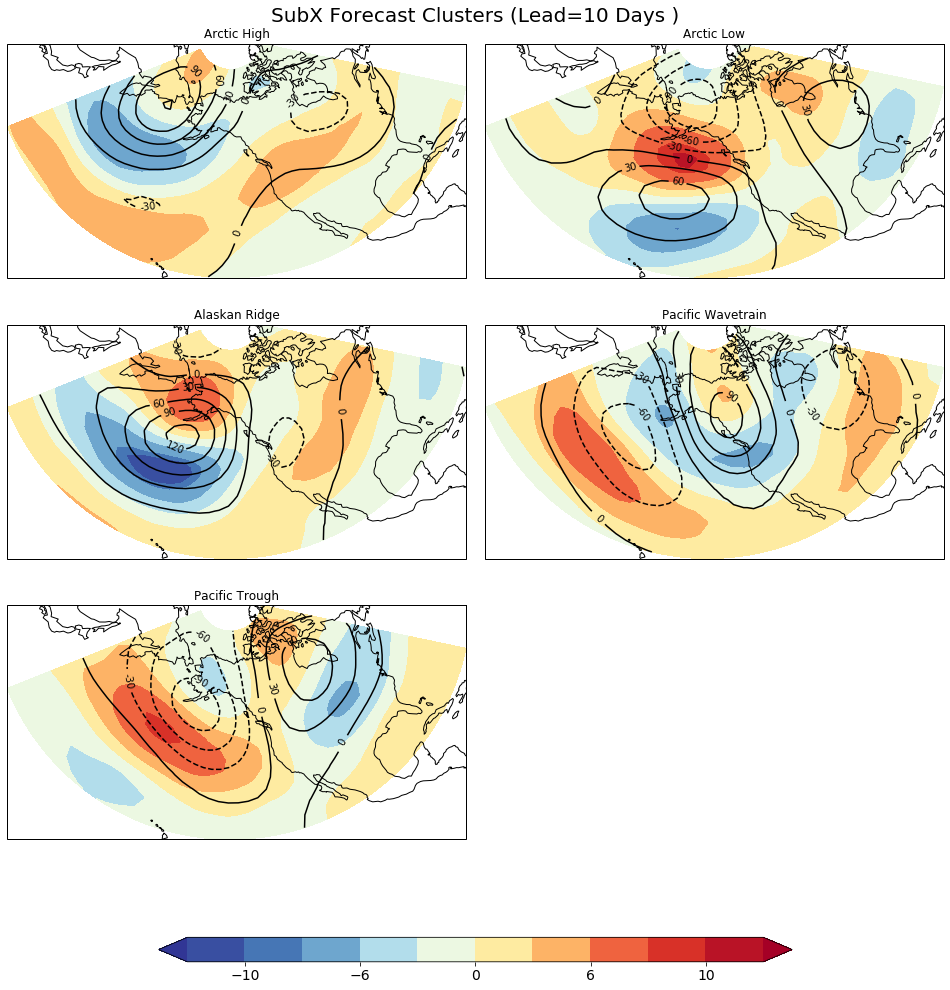

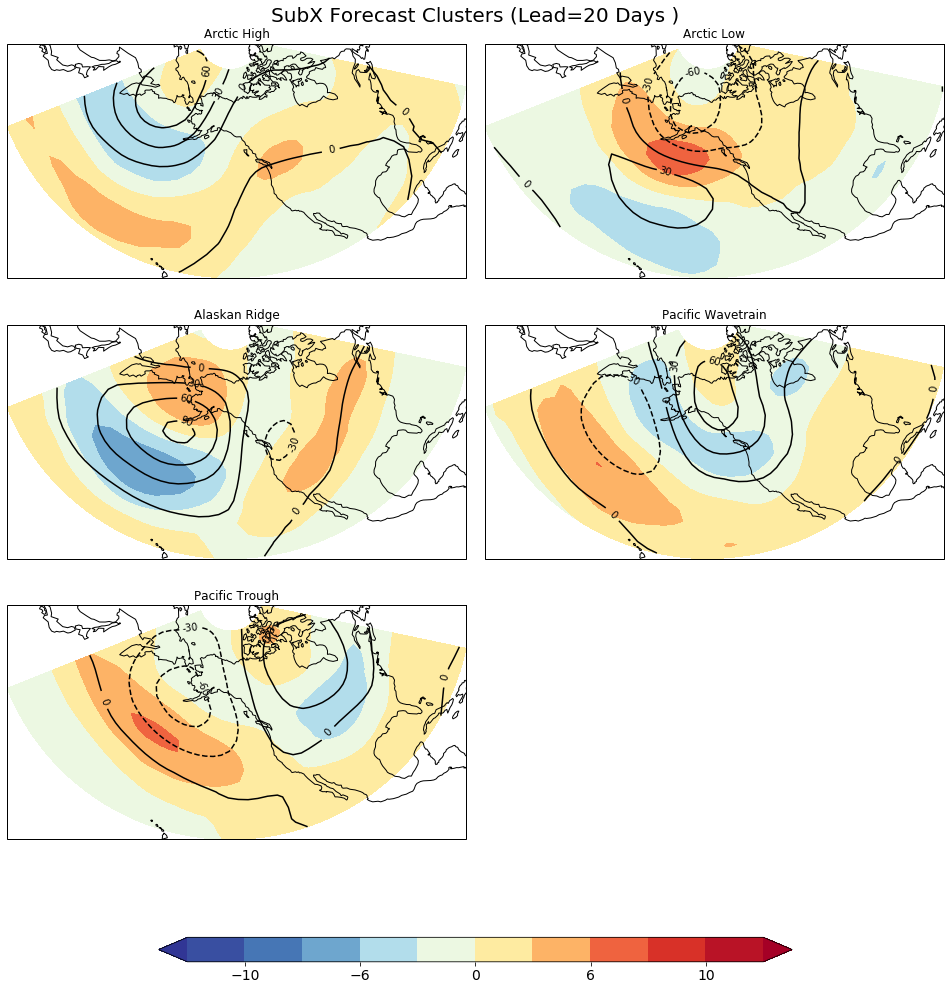

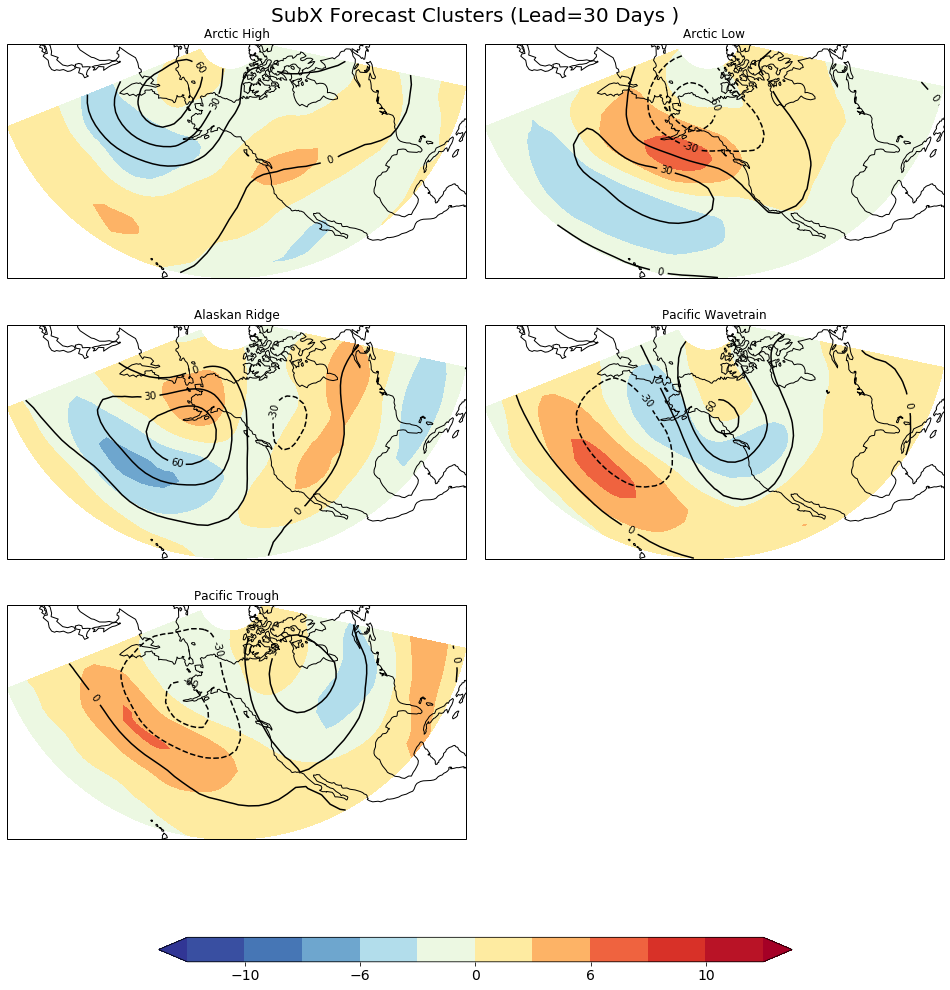

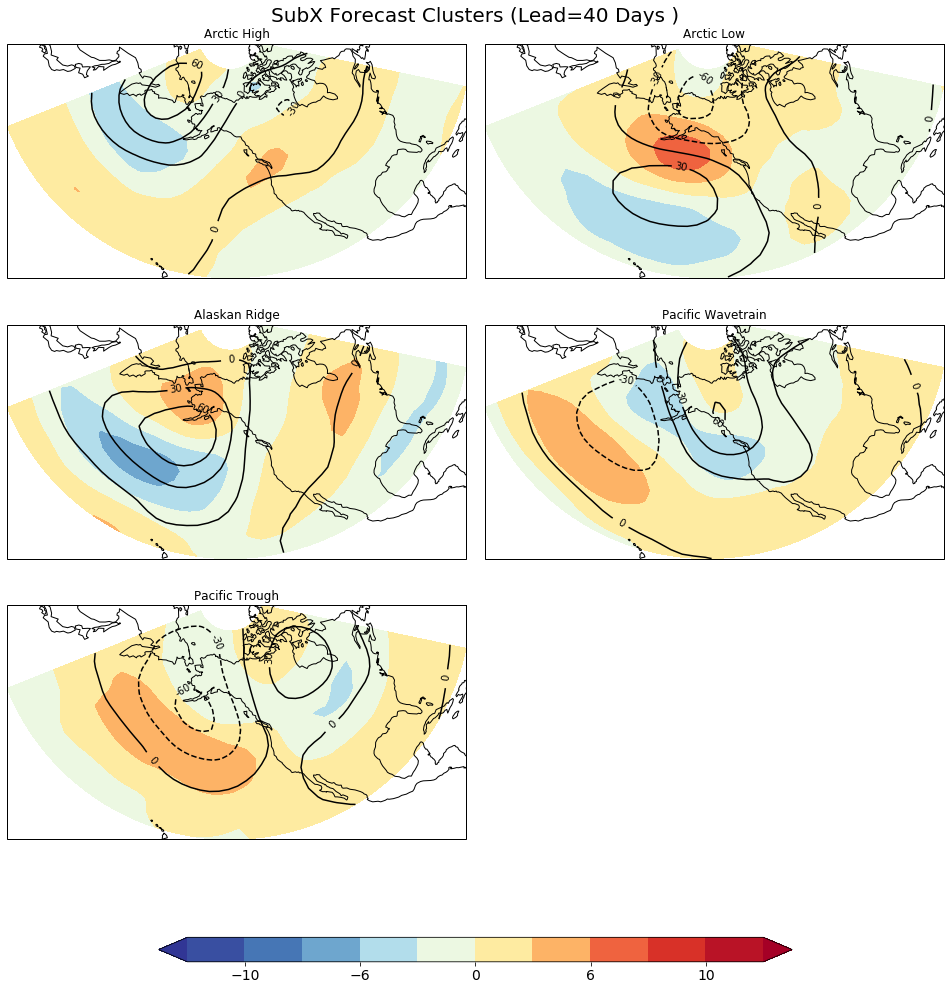

In [41]:
for ilead in range(0,nt,10):
    print(ilead)

#    cluster_freq=(ds_cluster['cluster'][:,ilead].groupby('cluster').count())/(nics)
#    freq=np.round(cluster_freq)
#    print(freq)
    fig,axs=plt.subplots(3,2,subplot_kw={'projection':proj},figsize=(22,17))

    for i,ax in enumerate(axs.flatten()):
#    ax.set_extent(extent)
        if (i < 5):
            cs=ax.contourf(cluster_comp['lon'],cluster_comp['lat'],
                           cluster_comp['u200'][ilead,i,:,:],clevs,
                           transform=ccrs.PlateCarree(),
                           cmap='RdYlBu_r',extend='both')
            cs2=ax.contour(cluster_comp['lon'],cluster_comp['lat'],
                           cluster_comp['z500'][ilead,i,:,:],levs,colors='k',
                           transform=ccrs.PlateCarree())

            ax.clabel(cs2,fmt='%2d')
            ax.set_title(titles[i]) # +' '+str(np.int(freq[i]))+'%',fontdict={'fontsize':16})
            ax.coastlines()
    fig.delaxes(axs.flatten()[5])    

    plt.suptitle('SubX Forecast Clusters (Lead='+str(ilead)+' Days )',fontsize=20)
    
    # Add Colorbar
    fig.subplots_adjust(bottom=0.3, top=0.95, left=0.2, right=0.8,
                        wspace=0.01, hspace=0.2)
    cbar_ax = fig.add_axes([0.3, 0.2, 0.4, 0.02])
    cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal')
    cbar.ax.tick_params(labelsize=14) 